In [2]:
import pandas as pd
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('data/telemetry.csv')

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
#What different types of events are there? 
df.groupby(df.event_name).size()

event_name
FirstInstall          386
IntroPlayed           188
LevelEnd            12214
LevelStart          12694
PurchaseComplete       39
dtype: int64

In [7]:
#number of distinct users, matches number of install events
total_users = len(pd.unique(df['user_id']))
print(total_users)

383


In [8]:
#total users where intro played
users_intro = len(pd.unique(df[df.event_name=='IntroPlayed']['user_id']))
print(users_intro)

186


In [9]:
df[df.event_name=='FirstInstall'].groupby('game_version').size()

game_version
A    198
B    188
dtype: int64

In [10]:
df[df.event_name=='IntroPlayed'].groupby('game_version').size()

game_version
A    188
dtype: int64

In [11]:
#total users where level 1 played
users_level1 = len(pd.unique(df[(df.event_name=='LevelStart')&(df.current_level==1)]['user_id']))
print(users_level1)

371


It looks like the intro only occured for version A. I wonder what's the purpose of the intro - does it help retention? Was it removed because numbers looked bad? 


### Retention

In [12]:
version_A = df[df.game_version=='A']
version_B = df[df.game_version=='B']

print(len(version_A))
print(len(version_B))
print(version_A.timestamp.min())
print(version_B.timestamp.min())

print(version_A.timestamp.max())
print(version_B.timestamp.max())

print(version_A[version_A.event_name=='FirstInstall'].timestamp.max())
print(version_B[version_B.event_name=='FirstInstall'].timestamp.max())

11988
13533
2019-10-24 13:36:00
2019-11-04 18:12:00
2019-11-17 23:45:00
2019-11-17 19:34:00
2019-11-13 13:28:00
2019-11-16 12:04:00


Version A was released on 10/24 and ran until 11/17. Version B was released on 11/04 and also ran until 11/17

In [13]:
install_date_A = version_A[version_A.event_name=='FirstInstall']
install_date_A['dt'] = install_date_A['timestamp'].apply(lambda x: datetime.date(x))

install_date_B = version_B[version_B.event_name=='FirstInstall']
install_date_B['dt'] = install_date_B['timestamp'].apply(lambda x: datetime.date(x))

print(install_date_A.groupby('dt').size())
print(install_date_B.groupby('dt').size())

dt
2019-10-24     8
2019-10-25    20
2019-10-26    15
2019-10-27    53
2019-10-28    82
2019-10-29     9
2019-10-30     3
2019-11-01     2
2019-11-03     1
2019-11-06     1
2019-11-07     1
2019-11-11     1
2019-11-12     1
2019-11-13     1
dtype: int64
dt
2019-11-04     8
2019-11-05    57
2019-11-06    77
2019-11-07    27
2019-11-08     3
2019-11-09     3
2019-11-10     1
2019-11-11     6
2019-11-12     2
2019-11-15     1
2019-11-16     3
dtype: int64


/Users/tatiaengelmore/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tatiaengelmore/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
#Calculate dates per user when first level played for each version
#I chose this rather than install because it shows retention based on 
#the first day of actual play, not just downloading the app. 
#Then compare to level starts for that same user. Did they come back the next day?

level1_date_version_A = version_A[((version_A.event_name=='LevelStart')&((version_A.current_level==1)))][['user_id', 'session_id','timestamp']]
level1_date_version_B = version_B[((version_B.event_name=='LevelStart')&((version_B.current_level==1)))][['user_id', 'session_id','timestamp']]


level_starts_version_A = version_A[version_A.event_name=='LevelStart']
level_starts_version_B = version_B[version_B.event_name=='LevelStart']



In [15]:
#Confirm users either only see one version while on level 1
level1_date_version_A.merge(level1_date_version_B, on='user_id')

,user_id,session_id_x,timestamp_x,session_id_y,timestamp_y


In [16]:
len(pd.unique(version_A.merge(version_B, on='user_id')['user_id']))

15

15 users see both versions at some point, so this isn't a clean division like in an AB test. I see users who install one version but start playing another version, so a bit of pollution in the results

In [17]:
level1_date_version_A['first_play_date'] = level1_date_version_A['timestamp'].apply(lambda x: datetime.date(x))
level1_date_version_B['first_play_date'] = level1_date_version_B['timestamp'].apply(lambda x: datetime.date(x))


#a couple users have duplicates of these events
level1_date_version_A = level1_date_version_A.groupby('user_id').min().reset_index()
level1_date_version_B = level1_date_version_B.groupby('user_id').min().reset_index()


In [18]:
level1_date_version_A.drop(['timestamp', 'session_id'], axis=1, inplace=True)
level1_date_version_B.drop(['timestamp', 'session_id'], axis=1, inplace=True)


In [19]:
level1_date_version_A.groupby('first_play_date').size()

first_play_date
2019-10-24     6
2019-10-25    21
2019-10-26    14
2019-10-27    49
2019-10-28    77
2019-10-29     7
2019-10-30     3
2019-11-01     2
2019-11-03     1
2019-11-05     1
2019-11-08     1
2019-11-11     1
2019-11-12     1
2019-11-13     1
dtype: int64

In [20]:
level1_date_version_B.groupby('first_play_date').size()

first_play_date
2019-11-04     8
2019-11-05    56
2019-11-06    76
2019-11-07    28
2019-11-08     3
2019-11-09     3
2019-11-10     1
2019-11-11     6
2019-11-12     2
2019-11-15     1
2019-11-16     2
dtype: int64

In [21]:
retention_version_A = level_starts_version_A.merge(level1_date_version_A, on='user_id', how='inner')
retention_version_B = level_starts_version_B.merge(level1_date_version_B, on='user_id', how='inner')

In [22]:
retention_version_A['day_number'] = (retention_version_A['timestamp'].apply(lambda x: datetime.date(x)) - retention_version_A['first_play_date']).dt.days
retention_version_B['day_number'] = (retention_version_B['timestamp'].apply(lambda x: datetime.date(x)) - retention_version_B['first_play_date']).dt.days


In [65]:
retention_version_A.groupby('user_id')['day_number'].max().mean()

3.3513513513513513

In [66]:
retention_version_B.groupby('user_id')['day_number'].max().mean()

2.6129032258064515

In [24]:
total_users_A = len(pd.unique(version_A['user_id']))
total_users_B = len(pd.unique(version_B['user_id']))

In [25]:
day1_retention_version_A = len(pd.unique(retention_version_A[retention_version_A.day_number==1]['user_id']))/total_users_A
day1_retention_version_B = len(pd.unique(retention_version_B[retention_version_B.day_number==1]['user_id']))/total_users_B

print(day1_retention_version_A)
print(day1_retention_version_B)

0.2857142857142857
0.25742574257425743


In [26]:
day_retention_A = retention_version_A.groupby('day_number')['user_id'].nunique().reset_index(name='retention')
day_retention_A['retention'] = day_retention_A['retention']/total_users_A

day_retention_B = retention_version_B.groupby('day_number')['user_id'].nunique().reset_index(name='retention')
day_retention_B['retention'] = day_retention_B['retention']/total_users_B

print(day_retention_A[:8])
print(day_retention_B[:8])

   day_number  retention
0           0   0.943878
1           1   0.285714
2           2   0.147959
3           3   0.091837
4           4   0.091837
5           5   0.081633
6           6   0.061224
7           7   0.056122
   day_number  retention
0           0   0.920792
1           1   0.257426
2           2   0.212871
3           3   0.183168
4           4   0.158416
5           5   0.143564
6           6   0.089109
7           7   0.113861


Some users above didn't have any level starts after installing. Slightly higher for A, maybe effect of intro? Actually no, this difference isn't statistically significant (after plugging into R). 

** How many users in B installed early enough to even show retention over 7 days? This is going to be an underestimate of B's retention because some users installed less than 7 days before the end of this dataset.  

In [27]:
day7_retention_version_A = len(pd.unique(retention_version_A[retention_version_A.day_number==7]['user_id']))/total_users_A
day7_retention_version_B = len(pd.unique(retention_version_B[retention_version_B.day_number==7]['user_id']))/total_users_B

print(day7_retention_version_A)
print(day7_retention_version_B)

0.05612244897959184
0.11386138613861387


Statistical significance is challenging here, but there's a clear trend: Group A has marginally better 1 day retention, but group B is better for longer term retention. 

In [28]:
#What level did people get to on day 1 for each group? 
max_day_1_A = retention_version_A[((retention_version_A.day_number==1)&(retention_version_A.event_name=='LevelStart'))].groupby('user_id')['current_level'].max().reset_index(name='max_level')['max_level'].mean()
max_day_2_A = retention_version_A[((retention_version_A.day_number==2)&(retention_version_A.event_name=='LevelStart'))].groupby('user_id')['current_level'].max().reset_index(name='max_level')['max_level'].mean()
max_day_3_A = retention_version_A[((retention_version_A.day_number==3)&(retention_version_A.event_name=='LevelStart'))].groupby('user_id')['current_level'].max().reset_index(name='max_level')['max_level'].mean()

print(max_day_1_A)
print(max_day_2_A)
print(max_day_3_A)

18.5
20.20689655172414
26.88888888888889


In [29]:
max_day_1_B = retention_version_B[((retention_version_B.day_number==1)&(retention_version_B.event_name=='LevelStart'))].groupby('user_id')['current_level'].max().reset_index(name='max_level')['max_level'].mean()
max_day_2_B = retention_version_B[((retention_version_B.day_number==2)&(retention_version_B.event_name=='LevelStart'))].groupby('user_id')['current_level'].max().reset_index(name='max_level')['max_level'].mean()
max_day_3_B = retention_version_B[((retention_version_B.day_number==3)&(retention_version_B.event_name=='LevelStart'))].groupby('user_id')['current_level'].max().reset_index(name='max_level')['max_level'].mean()


print(max_day_1_B)
print(max_day_2_B)
print(max_day_3_B)

18.692307692307693
26.093023255813954
31.35135135135135


People got about as far on day 1 in groups A and B, but started to diverge on day 2. 

In [30]:
#plot number of users per version per day

dau_A = retention_version_A.groupby('day_number').user_id.nunique().reset_index(name='num_users')
dau_B = retention_version_B.groupby('day_number').user_id.nunique().reset_index(name='num_users')
print(dau_A[:7])
print(dau_B[:7])

   day_number  num_users
0           0        185
1           1         56
2           2         29
3           3         18
4           4         18
5           5         16
6           6         12
   day_number  num_users
0           0        186
1           1         52
2           2         43
3           3         37
4           4         32
5           5         29
6           6         18


Take a look at sessions per day - is there a difference in engagement? 

In [31]:
sessions_per_day_A = retention_version_A.groupby('day_number')[['session_id', 'user_id']].nunique().reset_index()
sessions_per_day_B = retention_version_B.groupby('day_number')[['session_id', 'user_id']].nunique().reset_index()
sessions_per_day_A.columns=['day_number', 'sessions', 'users']
sessions_per_day_B.columns=['day_number', 'sessions', 'users']

sessions_per_day_A['sessions_per_user'] = sessions_per_day_A['sessions']/sessions_per_day_A['users']
sessions_per_day_B['sessions_per_user'] = sessions_per_day_B['sessions']/sessions_per_day_B['users']


print(sessions_per_day_A[:7])
print(sessions_per_day_B[:7])

   day_number  sessions  users  sessions_per_user
0           0       340    185           1.837838
1           1       171     56           3.053571
2           2        71     29           2.448276
3           3        52     18           2.888889
4           4        56     18           3.111111
5           5        51     16           3.187500
6           6        49     12           4.083333
   day_number  sessions  users  sessions_per_user
0           0       358    186           1.924731
1           1       167     52           3.211538
2           2       206     43           4.790698
3           3       126     37           3.405405
4           4        96     32           3.000000
5           5        84     29           2.896552
6           6        63     18           3.500000


Why does engagement go up so much on day 2 for version B? 

In [32]:
print(len(pd.unique(version_A['session_id']))/total_users_A)
print(len(pd.unique(version_B['session_id']))/total_users_B)

6.096938775510204
7.034653465346534


There are more sessions per user overall for version B. 

### Funnel

Let's look at where users dropped off in each version. Were users getting stuck at some point in version A? 

In [33]:
#number of distinct users starting each level
levels_A = version_A[version_A.event_name=='LevelStart'].groupby('current_level')['user_id'].nunique().reset_index(name='num_users_A')
levels_B = version_B[version_B.event_name=='LevelStart'].groupby('current_level')['user_id'].nunique().reset_index(name='num_users_B')


In [34]:
level_stats = levels_A.merge(levels_B, on='current_level')

In [35]:
level_stats['dropoff_A'] = level_stats['num_users_A'].diff().fillna(0)/level_stats['num_users_A'].shift(periods=1)
level_stats['dropoff_B'] = level_stats['num_users_B'].diff().fillna(0)/level_stats['num_users_B'].shift(periods=1)

In [68]:
level_stats = level_stats.fillna(0)
level_stats[10:30]

,current_level,num_users_A,num_users_B,dropoff_A,dropoff_B,pass_rate_A,pass_rate_B
10,11,75,80,-0.050633,-0.101124,0.393443,0.371287
11,12,67,72,-0.106667,-0.100000,0.945205,0.876543
12,13,67,71,0.000000,-0.013889,0.325123,0.316038
13,14,64,65,-0.044776,-0.084507,0.270270,0.344633
14,15,58,59,-0.093750,-0.092308,0.895522,0.797297
15,16,57,59,-0.017241,0.000000,0.662921,0.690476
16,17,57,56,0.000000,-0.050847,0.409722,0.394161
17,18,55,54,-0.035088,-0.035714,0.123967,0.158451
18,19,42,45,-0.236364,-0.166667,0.330769,0.411215
19,20,36,43,-0.142857,-0.044444,0.844444,0.900000


Were the difficulty levels of 18 and 19 changed between version A and B? Compare level difficulties. 

In [37]:
level_starts_A = version_A[version_A.event_name=='LevelStart'].groupby('current_level').size().reset_index(name='starts')
level_starts_B = version_B[version_B.event_name=='LevelStart'].groupby('current_level').size().reset_index(name='starts')

level_passes_A = version_A[((version_A.event_name=='LevelEnd')&(version_A.level_end_outcome=='pass'))].groupby('current_level').size().reset_index(name='passes')
level_fails_A = version_A[((version_A.event_name=='LevelEnd')&(version_A.level_end_outcome=='fail'))].groupby('current_level').size().reset_index(name='fails')
level_exits_A = version_A[((version_A.event_name=='LevelEnd')&(version_A.level_end_outcome=='exit'))].groupby('current_level').size().reset_index(name='exits')

level_passes_B = version_B[((version_B.event_name=='LevelEnd')&(version_B.level_end_outcome=='pass'))].groupby('current_level').size().reset_index(name='passes')
level_fails_B = version_B[((version_B.event_name=='LevelEnd')&(version_B.level_end_outcome=='fail'))].groupby('current_level').size().reset_index(name='fails')
level_exits_B = version_B[((version_B.event_name=='LevelEnd')&(version_B.level_end_outcome=='exit'))].groupby('current_level').size().reset_index(name='exits')


difficulties_A = level_starts_A.merge(level_passes_A, how='left', on='current_level').merge(level_fails_A, how='left', on='current_level').merge(level_exits_A, how='left', on='current_level').fillna(0)
difficulties_B = level_starts_B.merge(level_passes_B, how='left', on='current_level').merge(level_fails_B, how='left', on='current_level').merge(level_exits_B, how='left', on='current_level').fillna(0)

difficulties_A['pass_rate'] = difficulties_A['passes']/difficulties_A['starts']
difficulties_B['pass_rate'] = difficulties_B['passes']/difficulties_B['starts']


print(difficulties_B[:10])


   current_level  starts  passes  fails  exits  pass_rate
0              1     201     178    3.0    0.0   0.885572
1              2     181     157   14.0    2.0   0.867403
2              3     158     149    6.0    0.0   0.943038
3              4     175     135   30.0    1.0   0.771429
4              5     152     121   24.0    0.0   0.796053
5              6     217     108   95.0    0.0   0.497696
6              7     121      98    9.0    0.0   0.809917
7              8      96      95    2.0    0.0   0.989583
8              9     128      91   28.0    0.0   0.710938
9             10     157      90   65.0    2.0   0.573248


In [38]:
print(version_A[version_A.event_name=='LevelEnd'].groupby('level_end_outcome').size())

level_end_outcome
exit      32
fail    3216
pass    2415
dtype: int64


In [39]:
print(len(version_A[((version_A.event_name=='LevelEnd')&(version_A.current_level==1))]))
print(len(version_A[((version_A.event_name=='LevelStart')&(version_A.current_level==1))]))

180
201


In [40]:
level_stats['pass_rate_A'] = difficulties_A['pass_rate']
level_stats['pass_rate_B'] = difficulties_B['pass_rate']

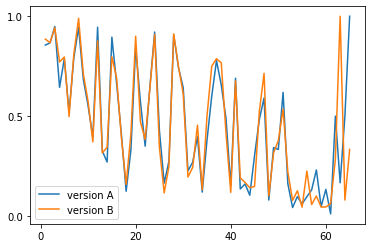

In [41]:
plt.plot(level_stats['current_level'], level_stats['pass_rate_A'], label='version A')
plt.plot(level_stats['current_level'], level_stats['pass_rate_B'], label='version B')
plt.legend()
plt.rcParams["figure.figsize"] = (35,15)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 24
plt.show()


In [42]:
level_stats[10:20]

,current_level,num_users_A,num_users_B,dropoff_A,dropoff_B,pass_rate_A,pass_rate_B
10,11,75,80,-0.050633,-0.101124,0.393443,0.371287
11,12,67,72,-0.106667,-0.100000,0.945205,0.876543
12,13,67,71,0.000000,-0.013889,0.325123,0.316038
13,14,64,65,-0.044776,-0.084507,0.270270,0.344633
14,15,58,59,-0.093750,-0.092308,0.895522,0.797297
15,16,57,59,-0.017241,0.000000,0.662921,0.690476
16,17,57,56,0.000000,-0.050847,0.409722,0.394161
17,18,55,54,-0.035088,-0.035714,0.123967,0.158451
18,19,42,45,-0.236364,-0.166667,0.330769,0.411215
19,20,36,43,-0.142857,-0.044444,0.844444,0.900000


It looks like between version A and B, levels 18-20 were maybe a bit easier in B. This may have reduced the total dropoff that was happening at that point, and this likely improved longer term retention (beyond the first day). However, the effect is very small and definitely not significant. 

In [43]:
max_level_A = version_A.groupby('user_id')['current_level'].max().reset_index(name='max_level')
max_level_B = version_B.groupby('user_id')['current_level'].max().reset_index(name='max_level')


In [44]:
mean_max_level_A = max_level_A['max_level'].mean()
mean_max_level_B = max_level_B['max_level'].mean()

print(mean_max_level_A)
print(mean_max_level_B)

12.505102040816327
15.727722772277227


In [45]:
#highest level reached
df['current_level'].max()

65

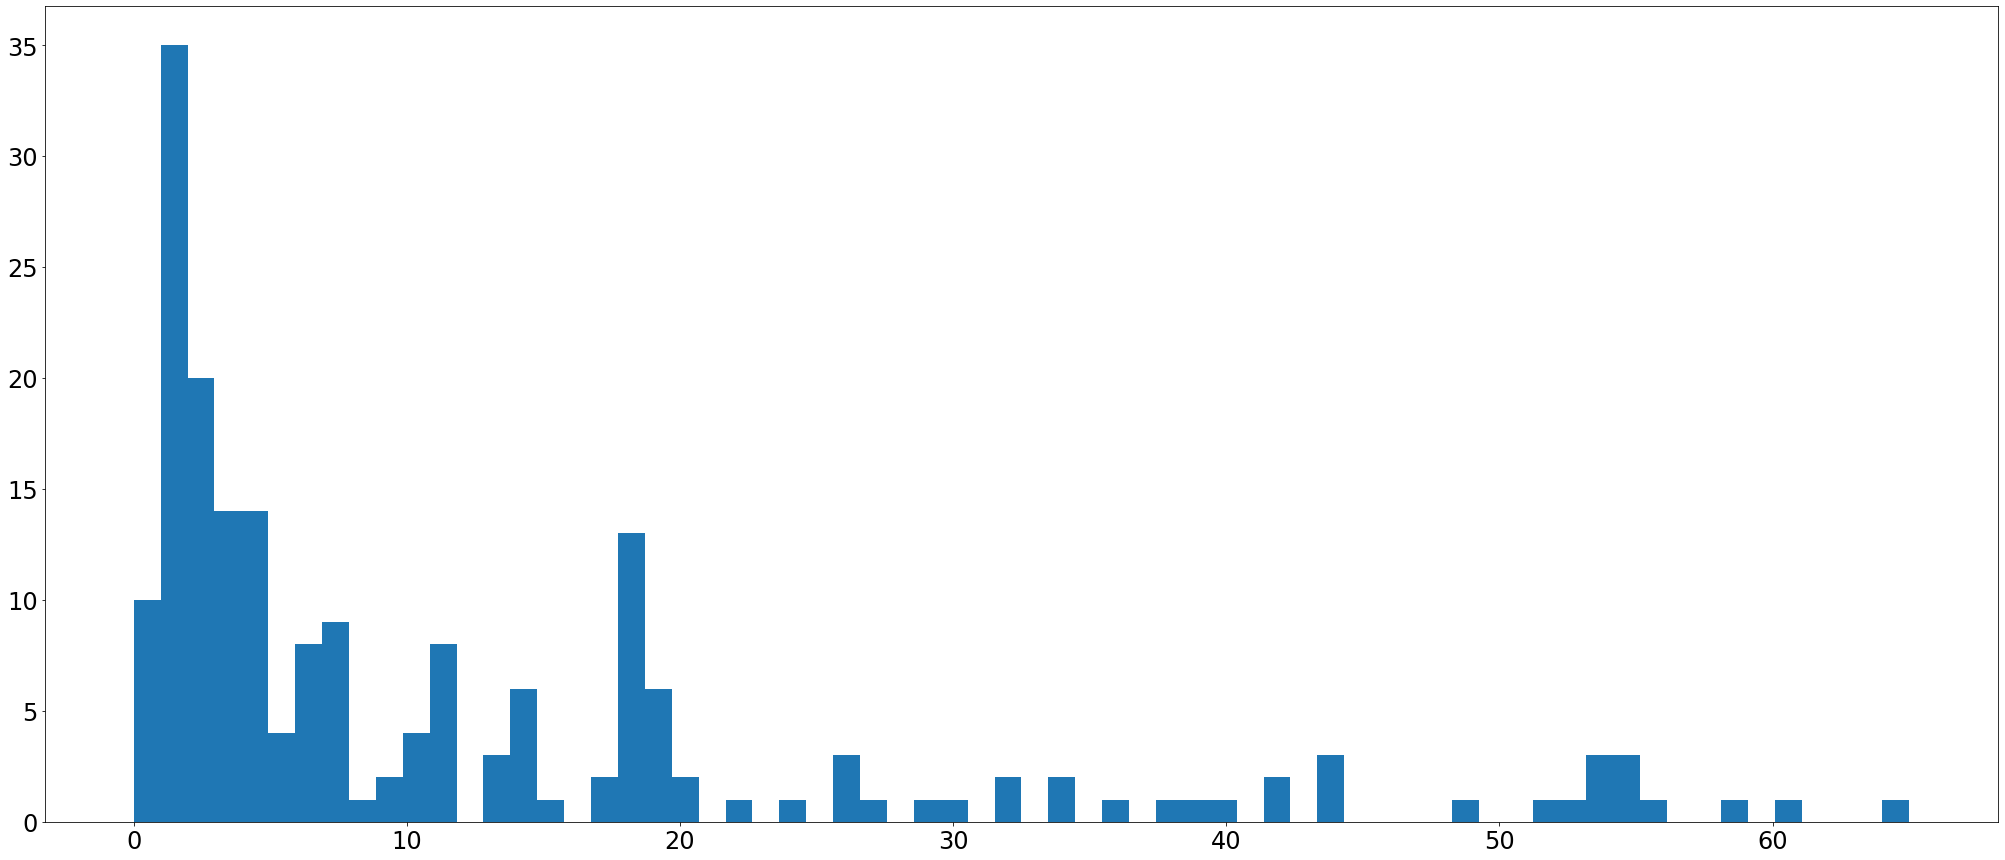

In [46]:
plt.hist(max_level_A['max_level'], bins=66)
plt.show()

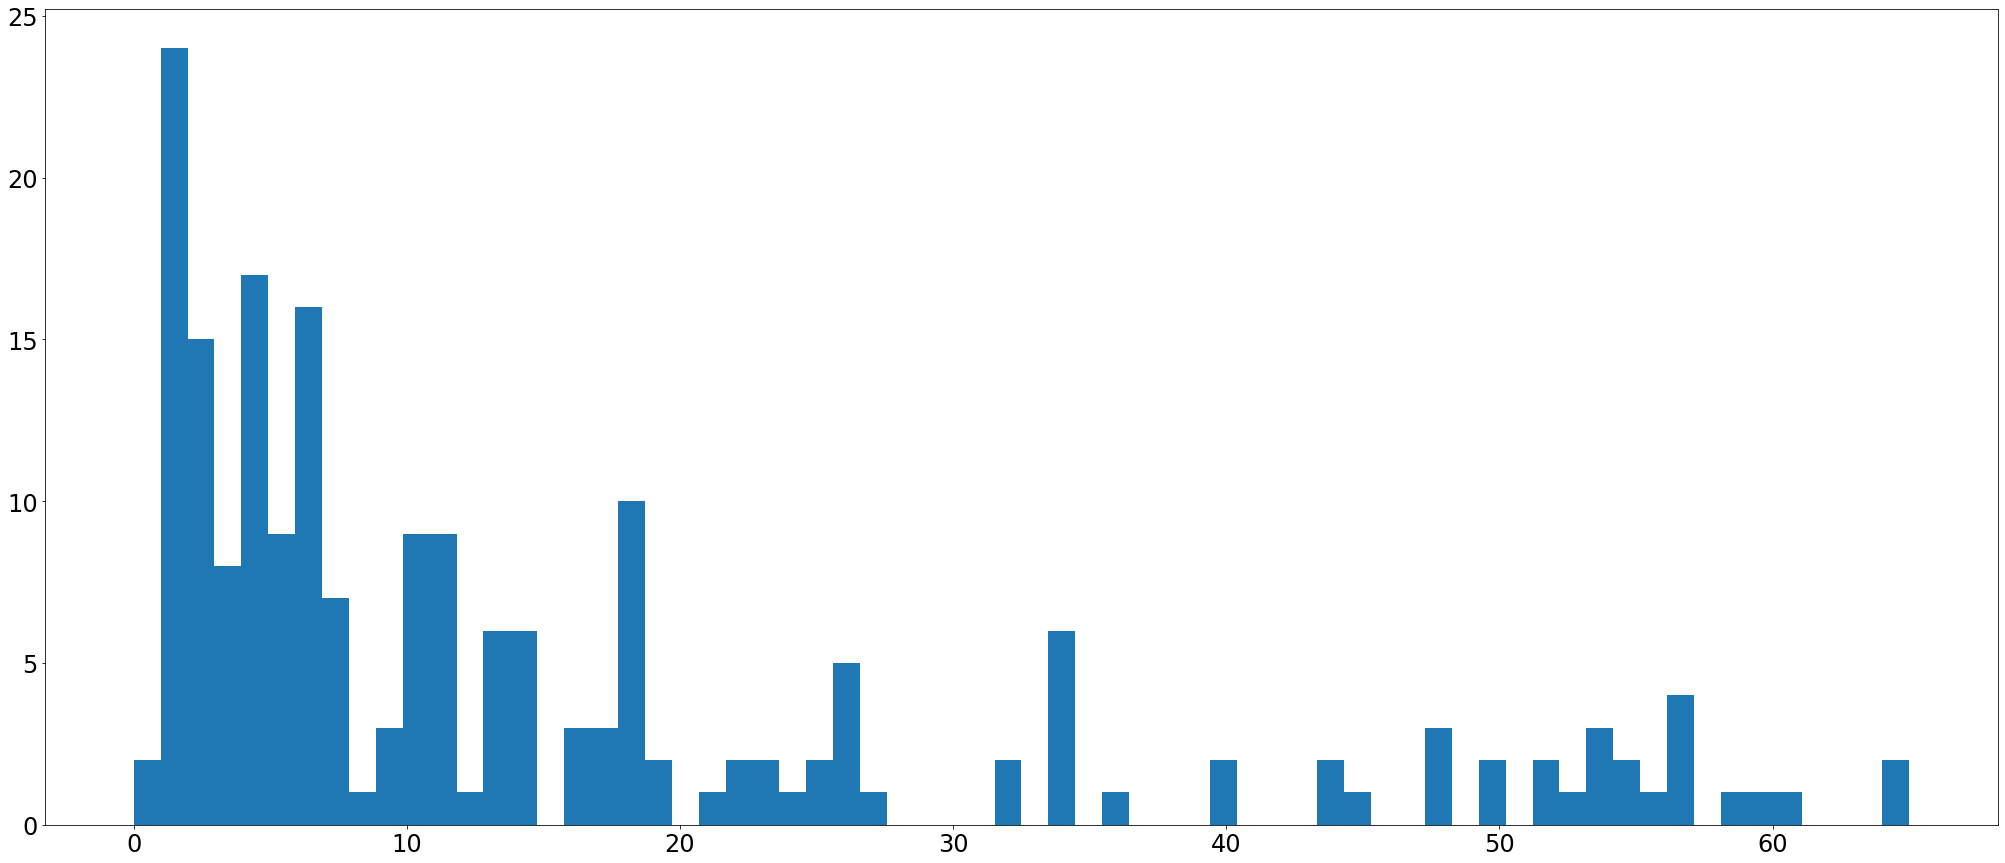

In [47]:
plt.hist(max_level_B['max_level'], bins=66)
plt.show()

In [48]:
max_level_B.groupby('max_level').size().reset_index(name='level').sort_values(by='level', ascending=False)[:10]

,max_level,level
1,1,24
4,4,17
6,6,16
2,2,15
17,18,10
11,11,9
10,10,9
5,5,9
3,3,8
7,7,7


In [49]:
max_level_A.groupby('max_level').size().reset_index(name='level').sort_values(by='level', ascending=False)[:10]

,max_level,level
1,1,35
2,2,20
3,3,14
4,4,14
16,18,13
0,0,10
7,7,9
6,6,8
11,11,8
13,14,6


What are the pass rates by level for version A vs. B? 

### Purchase Events
How many players make a purchase, for how much, and what leads them to start spending money? 

In [50]:
#How many have paid?
payers_A = len(pd.unique(version_A[version_A.event_name=='PurchaseComplete']['user_id']))
frac_payers_A = payers_A/total_users_A

payers_B = len(pd.unique(version_B[version_B.event_name=='PurchaseComplete']['user_id']))
frac_payers_B = payers_B/total_users_B

print(payers_A)
print(frac_payers_A)

print(payers_B)
print(frac_payers_B)

17
0.08673469387755102
14
0.06930693069306931


We have 31 paying users, or 8.1% of the total

In [51]:
#Total amount spent
total_spend_A = version_A[version_A.iap_value.notnull()]['iap_value'].sum()
total_spend_B = version_B[version_B.iap_value.notnull()]['iap_value'].sum()

print(total_spend_A)
print(total_spend_B)

150.0
50.0


We've made $200! Now let's calculate the ARPU and ARPPU

In [52]:
arpu_A = total_spend_A/total_users_A
arppu_A = total_spend_A/payers_A

arpu_B = total_spend_B/total_users_B
arppu_B = total_spend_B/payers_B

print(arpu_A)
print(arppu_A)

print(arpu_B)
print(arppu_B)

0.7653061224489796
8.823529411764707
0.24752475247524752
3.5714285714285716


Let's also look at the distribution of spend and see if we can identify any whales. 

In [53]:
median_spend = df[df.iap_value.notnull()]['iap_value'].median()
print(median_spend)
df[((df.iap_value.notnull())&(df.iap_value>3*median_spend))].groupby('user_id')['iap_value'].sum()

2.0


user_id
2EE0CF20920B3D95    20.0
B9AB38CED8FD4ECA    20.0
F498B4A28D85B55B    20.0
F760471386212A06    70.0
Name: iap_value, dtype: float64

In [54]:
#How many purchases for our whale, F760471386212A06?
df[((df.user_id=='F760471386212A06')&(df.iap_value.notnull()))]

,user_id,event_name,timestamp,game_version,session_id,current_level,level_end_outcome,iap_value
25205,F760471386212A06,PurchaseComplete,2019-10-30 16:28:00,A,0b3ea8ee-0ca4-4990-83d4-61095c89b118,42,NaN,70.0


In [55]:
max_dt = df.timestamp.max()
min_dt = df.timestamp.min()
print(max_dt)
print(min_dt)

2019-11-17 23:45:00
2019-10-24 13:36:00


In [56]:
#How much spend occured by version? 
versionA_spend = version_A[version_A.iap_value.notnull()]['iap_value'].sum()
versionB_spend = version_B[version_B.iap_value.notnull()]['iap_value'].sum()

print(versionA_spend)
print(versionB_spend)

150.0
50.0


In [74]:
#removing the whale in A

total_spend_A_dewhaled = version_A[((version_A.iap_value.notnull())&(version_A.user_id != "F760471386212A06"))]['iap_value'].sum()
print(total_spend_A_dewhaled)
#now 16 payers left, total spend = 80

arpu_A_dewhaled = total_spend_A_dewhaled/(total_users_A-1)
print(arpu_A_dewhaled)
arppu_A_dewhaled = total_spend_A_dewhaled/16
print(arppu_A_dewhaled)

80.0
0.41025641025641024
5.0


More was spent on version A, but this isn't surprising - users had a lot longer time in version A, so more chance to spend money

In [57]:
#What level did purchases happen on? 
#Make a histogram of purchase 
purchase_levels_A = version_A[version_A.event_name=='PurchaseComplete'].groupby('current_level')['iap_value'].sum().reset_index(name='total_spend')
purchase_levels_B = version_B[version_B.event_name=='PurchaseComplete'].groupby('current_level')['iap_value'].sum().reset_index(name='total_spend')


print(purchase_levels_A)
print(purchase_levels_B)

    current_level  total_spend
0              11          6.0
1              12          2.0
2              13         22.0
3              14          6.0
4              17          2.0
5              18          2.0
6              19          2.0
7              23          2.0
8              27          2.0
9              34          2.0
10             42         70.0
11             44          2.0
12             49          2.0
13             53         22.0
14             54          2.0
15             58          2.0
16             59          2.0
    current_level  total_spend
0              16          2.0
1              17          6.0
2              18          2.0
3              30          2.0
4              34          2.0
5              40          2.0
6              42         20.0
7              43          2.0
8              44          4.0
9              45          2.0
10             48          2.0
11             53          2.0
12             55          2.0


See large amount of spend (from one user?) on level 42 for both variants. 
No spend before level 16 in variant B - did this contribute to retention somehow? Lower retention early on without any spend, then higher retention later on with spending. When are purchases introduced in the game? First hard levels are 11, 13 and 14. Maybe users frustrated if they're not offered the ability to spend then?  It would be useful to know when in game purchases are introduced. 

In [58]:
pd.unique(version_A[version_A.event_name=='PurchaseComplete']['iap_value'])

array([ 2., 20., 70.])

In [59]:
pd.unique(version_B[version_B.event_name=='PurchaseComplete']['iap_value'])

array([ 2., 20.])

In [60]:
#What day do these purchases happen? 
payments_A = version_A[version_A.iap_value.notnull()][['user_id', 'iap_value', 'current_level', 'timestamp']]
payments_A = payments_A.merge(level1_date_version_A, on='user_id')

payments_B = version_B[version_B.iap_value.notnull()][['user_id', 'iap_value', 'current_level', 'timestamp']]
payments_B = payments_B.merge(level1_date_version_B, on='user_id')

payments_A['day_number'] = (payments_A['timestamp'].apply(lambda x: datetime.date(x)) - payments_A['first_play_date']).dt.days
payments_B['day_number'] = (payments_B['timestamp'].apply(lambda x: datetime.date(x)) - payments_B['first_play_date']).dt.days

print(payments_A['day_number'].mean())
print(payments_B['day_number'].mean())



7.130434782608695
3.9375


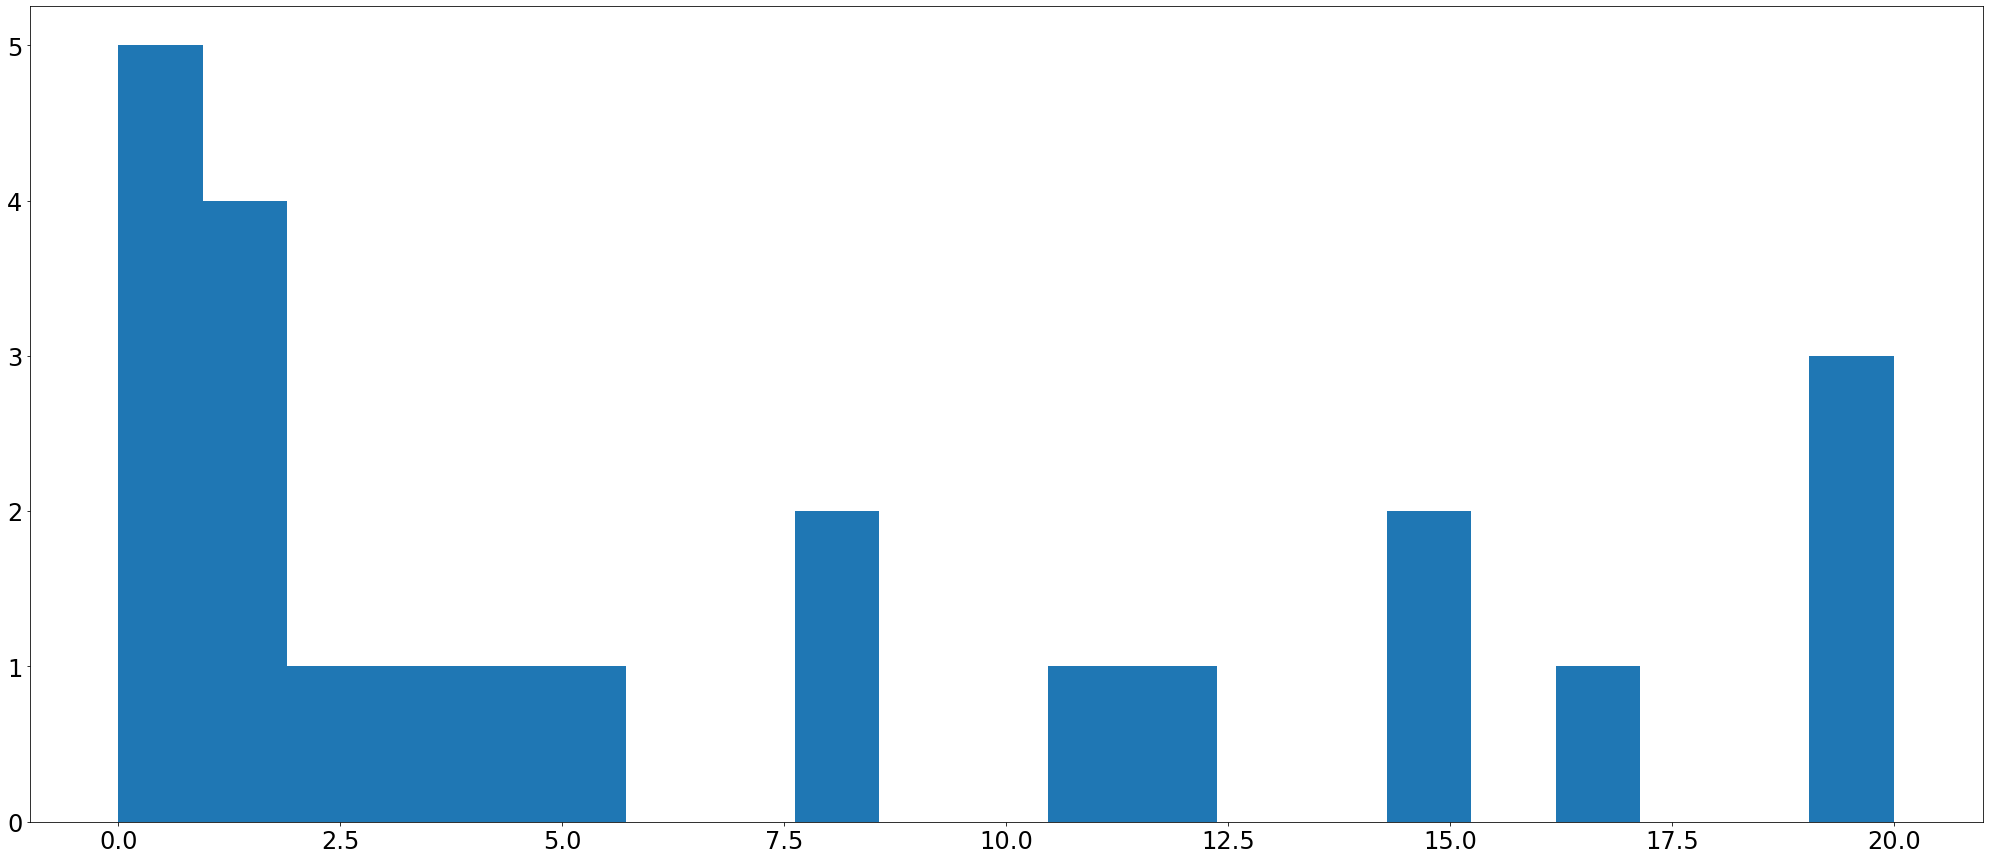

In [61]:
plt.hist(payments_A['day_number'], bins=21)
plt.show()

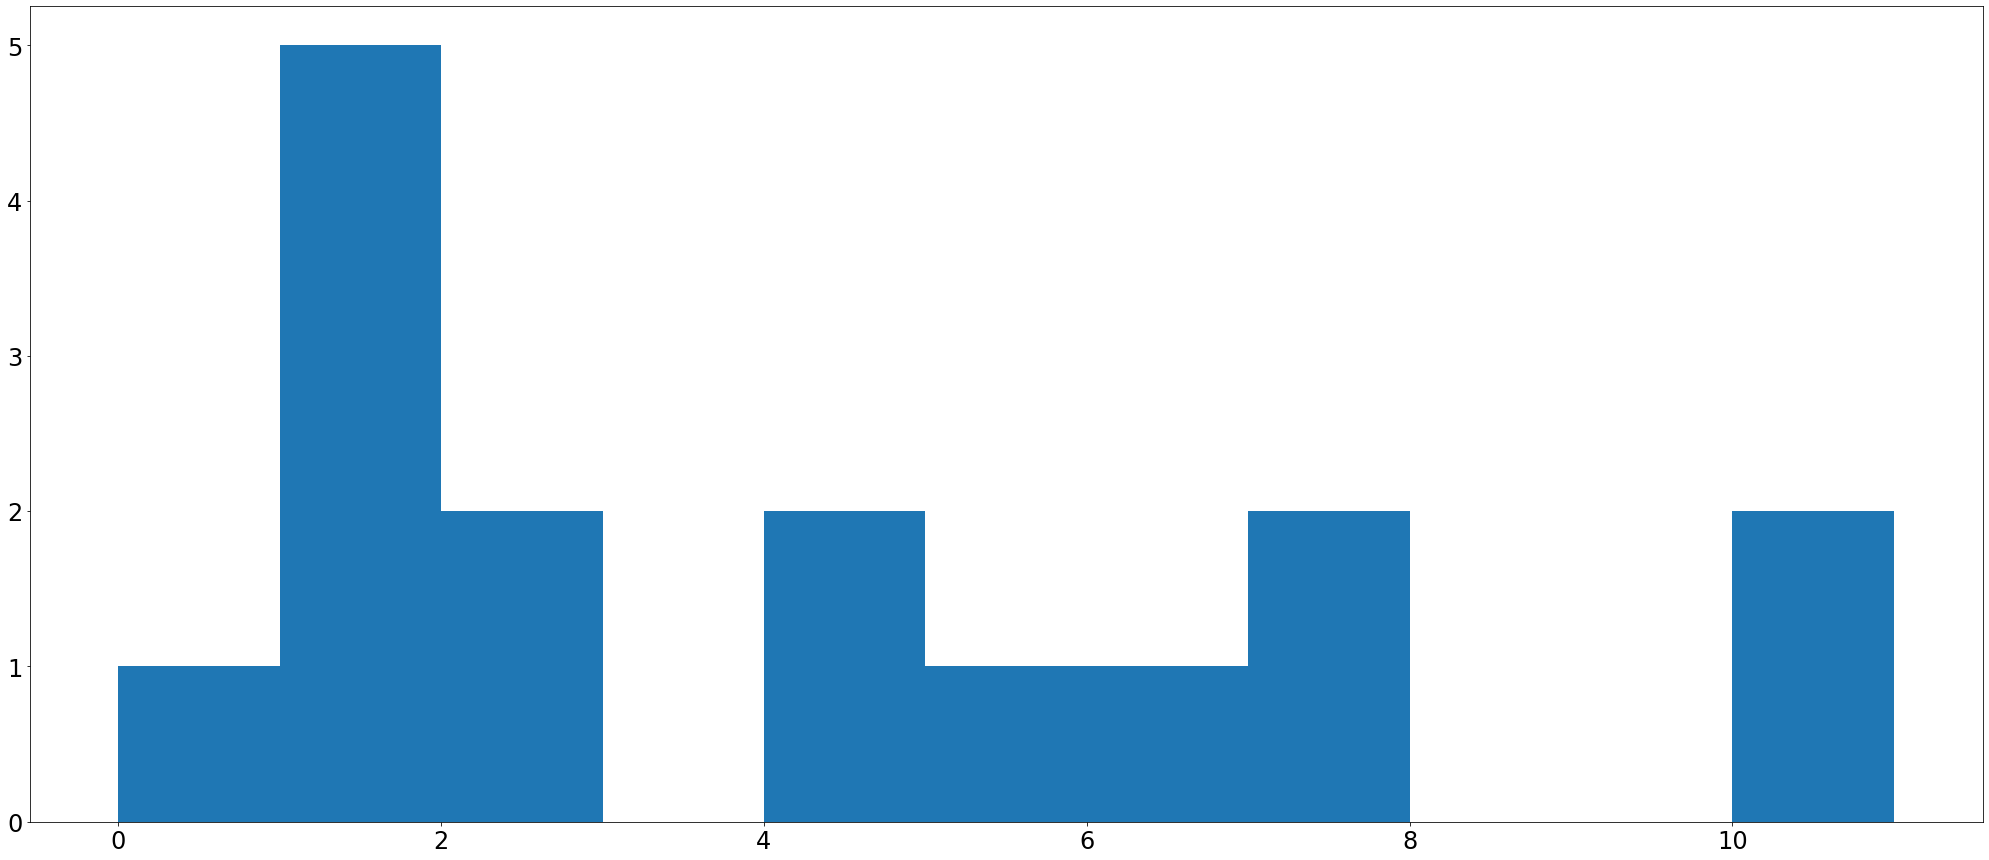

In [62]:
plt.hist(payments_B['day_number'], bins=11)
plt.show()

In [63]:
payments_A.sort_values(by='day_number')

,user_id,iap_value,current_level,timestamp,first_play_date,day_number
1,38A4BC9A7B4B713F,2.0,13,2019-10-27 06:28:00,2019-10-27,0
2,2EE0CF20920B3D95,20.0,13,2019-10-29 12:56:00,2019-10-29,0
14,ECC3E3A2FECAA733,2.0,11,2019-10-27 03:30:00,2019-10-27,0
12,CEDBE9F0D13B79,2.0,12,2019-10-27 12:02:00,2019-10-27,0
10,174325D74F4D1027,2.0,11,2019-10-28 11:55:00,2019-10-28,0
11,6063848A990FF4AD,2.0,18,2019-10-28 13:34:00,2019-10-27,1
16,F84AC26468C9456C,2.0,23,2019-10-29 05:38:00,2019-10-28,1
4,F498B4A28D85B55B,2.0,14,2019-10-25 07:18:00,2019-10-24,1
13,FB2CAA0165A99E6E,2.0,17,2019-10-28 14:45:00,2019-10-27,1
8,4A60072EAA2ECD88,2.0,14,2019-10-29 01:20:00,2019-10-27,2


In [64]:
payments_B.sort_values(by='day_number')

,user_id,iap_value,current_level,timestamp,first_play_date,day_number
7,6DFE85E2C4214A11,2.0,17,2019-11-05 02:54:00,2019-11-05,0
1,702A40AFF47424DE,2.0,17,2019-11-06 03:07:00,2019-11-05,1
4,C6B4DECDACA94763,2.0,18,2019-11-07 04:41:00,2019-11-06,1
6,761E883034F489EF,2.0,17,2019-11-07 04:02:00,2019-11-06,1
10,2062F9CB71AD1AFB,2.0,30,2019-11-06 19:28:00,2019-11-05,1
14,665F25509C350C7D,2.0,34,2019-11-10 21:35:00,2019-11-09,1
3,A170368B6F3C2464,2.0,40,2019-11-07 07:08:00,2019-11-05,2
13,C384546AE46F488B,2.0,44,2019-11-11 02:15:00,2019-11-09,2
5,24B12AC49BDE9518,2.0,43,2019-11-10 12:36:00,2019-11-06,4
11,2062F9CB71AD1AFB,2.0,45,2019-11-09 05:32:00,2019-11-05,4
